# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression of climatological fields on OMET with vertical profile in certain seasons** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.11.08 ** <br>
** Last Update  : 2019.01.03 ** <br>
Description     : This notebook includes the result of the lag regression of climatological fields (e.g. T,z,v,du/dz) on OMET in winter and summer. It aims to unveil the relation between the climatological fields and OMET and try to illustrate how the ocean drives the atmosphere through the change of OMET.<br>
To have a clear insight about the relation between OMET and AMET, regressions of AMET components on pressure level on OMET are included here as well.<br>

This script will take the autocorrelation into account for the quantification of statistical significance. The plots illustrate regression coefficients.<br>

Return Values   : jpeg <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2014
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [10]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
    output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Compensation/MET_mechanism/OMET/vert'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_vert = Dataset(os.path.join(datapath_ERAI_fields,
                                       'pressure_erai_monthly_regress_1979_2017_vertProfile_dudz_psi_var3D.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                 'oras_model_monthly_1958_2017_omet.nc'))
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    dataset_ERAI_E_vert = Dataset(os.path.join(datapath_ERAI_fields,
                                  'pressure_erai_monthly_regress_1979_2017_vertProfile_E.nc'))
    #################################   Extract variabels  ##############################
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 4D fields [year, month, lat, lon]
    # vertical profile of multiple fields
    t_vert = dataset_ERAI_fields_vert.variables['t_vert'][:-1,:,:,:]
    z_vert = dataset_ERAI_fields_vert.variables['z_vert'][:-1,:,:,:]
    v_vert = dataset_ERAI_fields_vert.variables['v_vert'][:-1,:,:,:]
    dudz_vert = dataset_ERAI_fields_vert.variables['dudz_vert'][:-1,:,:,:]
    psi_vert = dataset_ERAI_fields_vert.variables['psi_vert'][:-1,:,:,:] / 1E+10 # already weighted by lat
    # vertical profile of AMET
    cpT_vert = dataset_ERAI_E_vert.variables['cpt_vert'][:-1,:,:,:] / 1000
    gz_vert = dataset_ERAI_E_vert.variables['gz_vert'][:-1,:,:,:] / 1000
    Lvq_vert = dataset_ERAI_E_vert.variables['Lvq_vert'][:-1,:,:,:] / 1000
    E_vert = dataset_ERAI_E_vert.variables['E_vert'][:-1,:,:,:] / 1000
    # 3D fields [year, month, lat]
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][21:-1,:,180:]/1000
    OMET_atl_100_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_100_int'][21:-1,:,180:]/1000
    OMET_atl_300_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_300_int'][21:-1,:,180:]/1000
    OMET_atl_700_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_700_int'][21:-1,:,180:]/1000
    OMET_atl_2000_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_2000_int'][21:-1,:,180:]/1000
    
    OMET_pac_int_ORAS4 = dataset_ORAS4_OMET.variables['E_pac_int'][21:-1,:,180:]/1000  
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:-1]    # from 1979 to 2016
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    gphiv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['gphiv'][180:,:]
    glamv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['glamv'][180:,:]
    latitude_fields_vert_ERAI = dataset_ERAI_fields_vert.variables['latitude'][:]
    level_fields_vert_ERAI = dataset_ERAI_fields_vert.variables['level'][:]
    mask_ORAS4 = dataset_ORAS4_mask.variables['vmask'][0,0,180:,:]
    # area weighted surface flux
    t_vert_weight = np.zeros(t_vert.shape, dtype=float)
    z_vert_weight = np.zeros(z_vert.shape, dtype=float)
    v_vert_weight = np.zeros(v_vert.shape, dtype=float)
    dudz_vert_weight = np.zeros(dudz_vert.shape, dtype=float)
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_vert_ERAI / 360)
    for i in np.arange(len(latitude_fields_vert_ERAI)):
        # change the unit to terawatt
        t_vert_weight[:,:,:,i] = t_vert[:,:,:,i]* dx[i] / dx[-1]
        z_vert_weight[:,:,:,i] = z_vert[:,:,:,i]* dx[i] / dx[-1]
        v_vert_weight[:,:,:,i] = v_vert[:,:,:,i]* dx[i] / dx[-1]
        dudz_vert_weight[:,:,:,i] = dudz_vert[:,:,:,i]* dx[i] / dx[-1]

*********************** extract variables *************************


To quantify the static stability, we have to calculate the potential temperature. <br>
$$ \theta = T * (\frac{p_0}{p})^(\frac{R}{c_p})$$
where $T$ is the absolute temperature in Kelvin, $p_0$ is the reference pressure, $\frac{R}{c_p} = 0.286$ <br>
<br>
The static stability (SS) can be investigated through: <br>
$$ \sigma = \frac{\partial \theta}{\partial p} $$
Large $\sigma$ indicates the air parcels in a vertical column are stable. This factor gives the adiabatic heating graident with respect to pressure. When $\sigma$ is large, there is large temperature difference between layers and there exists a strong restoring force for the movement of the air parcel. On the contary, when the temperature difference at the surrounding is not very different, the air parcels are highly unstable as there is no restoring force against the motion of them. Such state is known as the adiabatic equilibrium. <br>

In [11]:
    ##############################   static stability  ###################################
    # calculate the potential temperature
    theta = np.zeros(t_vert.shape, dtype=float)
    for i in np.arange(len(level_fields_vert_ERAI)):
        theta[:,:,i,:] = t_vert[:,:,i,:] * (1000/level_fields_vert_ERAI[i]) ** (constant['R_dry'] / constant['cp'])
    # calculate the static stability
    Sigma = np.zeros(t_vert.shape, dtype=float)
    for i in np.arange(len(level_fields_vert_ERAI)-1):
        Sigma[:,:,i+1,:] = (theta[:,:,i+1,:] - theta[:,:,i,:]) / (level_fields_vert_ERAI[i+1]-level_fields_vert_ERAI[i])

Table for an easy lead / lag analysis of seasonal data <br>

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |winter|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JFM |FMA |MAM |AMJ |MJJ |JJA |JAS |ASO |SON |OND |NDJ |DJF   |

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |summer|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JAS |ASO |SON |OND |NDJ |DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |

In [7]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

***********!@#$%^&*     Hadley circulation   !@#$%^&***********
======================   OMET + atl + 60N & t vert winter  =====================


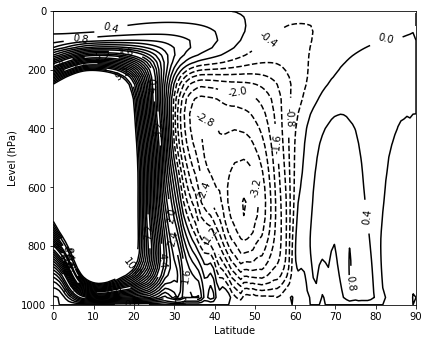

In [27]:
    print ('***********!@#$%^&*     Hadley circulation   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & t vert winter  =====================')
    psi_season_series = meta.statistics.operator.seasons(psi_vert[:], span='DJF', Dim_month=True)
    psi_mean = np.mean(psi_season_series,0)
    ticks = [i for i in np.linspace(-10,10,51)]
    label = 'Stokes Stream Function 1E+10 kg/s'
    # make plots
    fig = plt.figure(figsize=(6.5,5.4))        
    cs = plt.contour(latitude_fields_vert_ERAI, level_fields_vert_ERAI, psi_mean,
                     levels=ticks, colors='k', extend='both')
    plt.clabel(cs, inline=True, inline_spacing = 8, fontsize = 10, fmt = '%1.1f')
    #cbar = fig.colorbar(cs,extend='both', orientation='horizontal',
    #                    shrink =0.8, pad=0.135, format="%.3f")
    #cbar.set_label(label,size = 10)
    #cbar.set_ticks(ticks)
    #cbar.ax.tick_params(labelsize = 10)
    plt.xlabel("Latitude")
    plt.ylabel("Level (hPa)")
    #invert the y axis
    plt.gca().invert_yaxis()
    plt.show()
    fig.savefig(os.path.join(output_path, 'omet_fields','psi_ERAI_DJF.png'),dpi=400)
    plt.close(fig)    



***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & t vert winter  =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create contour plot of correlation coefficient for vertical profiles.


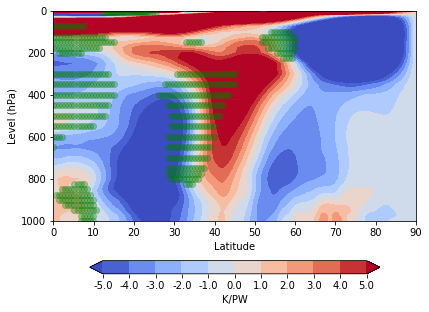

In [8]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & t vert winter  =====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    t_vert_season_series = meta.statistics.operator.seasons(t_vert_weight[:],
                                                            span=lag_winter[lag], Dim_month=True)
    stat_t_vert_ERAI = meta.statistics.operator(t_vert_season_series[3:])
    stat_t_vert_ERAI.anomaly(Dim_month=False)
    stat_t_vert_ERAI.detrend()
    stat_t_vert_ERAI.lowpass(window=30, obj='detrend')
    
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_t_vert_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_t_vert_ERAI._detrend) 
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    #label = 'Correlation coefficient'
    ticks = [i for i in np.linspace(-5,5,11)]
    label = 'K/PW'
    meta.visualizer.plots.vertProfile(latitude_fields_vert_ERAI, level_fields_vert_ERAI, k, p_real,
                                      label, ticks, os.path.join(output_path, 'omet_fields',
                                      'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_t_vert_DJF_decadal.png'.format(lag)),
                                      ttest=True)
    #print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & d theta / dp winter  =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create contour plot of correlation coefficient for vertical profiles.


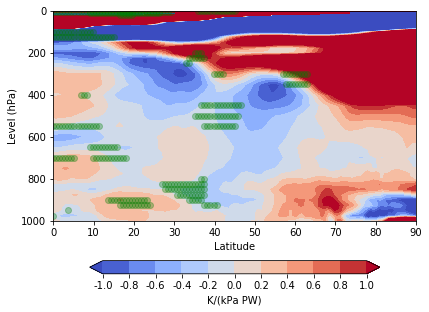

[[-0.28507368 -0.2890899  -0.29031827 -0.28787258 -0.2812892  -0.27119667
  -0.25818356 -0.24406216 -0.23093987 -0.21999069]
 [ 0.14151401  0.13710166  0.13493096  0.13527765  0.13751465  0.14039386
   0.14394355  0.14834082  0.15339712  0.16016527]
 [ 0.25220085  0.23313912  0.2151914   0.20068865  0.18949436  0.18033747
   0.17320057  0.16767898  0.16383895  0.16163908]
 [ 0.10625717  0.09009938  0.07605432  0.06447195  0.05396479  0.04432009
   0.03682043  0.03082811  0.02565237  0.02139169]
 [ 0.10957637  0.09954453  0.08931775  0.07864748  0.0671644   0.05512647
   0.04420477  0.0359675   0.03049565  0.02545637]
 [ 0.42953572  0.42118161  0.41091169  0.39683548  0.37964103  0.36191712
   0.34349076  0.32432475  0.30578204  0.28890033]
 [ 0.55475467  0.53338989  0.5115685   0.48734221  0.46232356  0.43786302
   0.41103632  0.3827501   0.35496495  0.32789873]
 [ 0.39634756  0.35817304  0.32094737  0.28557654  0.2520484   0.22044869
   0.19174559  0.1649479   0.13900033  0.11454136]


In [33]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & d theta / dp winter  =====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    theta_vert_season_series = meta.statistics.operator.seasons(Sigma[:],
                                                            span=lag_winter[lag], Dim_month=True)
    stat_theta_vert_ERAI = meta.statistics.operator(theta_vert_season_series[3:])
    stat_theta_vert_ERAI.anomaly(Dim_month=False)
    stat_theta_vert_ERAI.detrend()
    stat_theta_vert_ERAI.lowpass(window=30, obj='detrend')
    
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_theta_vert_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_theta_vert_ERAI._detrend) 
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    #label = 'Correlation coefficient'
    ticks = [i for i in np.linspace(-1,1,11)]
    label = 'K/(kPa PW)'
    meta.visualizer.plots.vertProfile(latitude_fields_vert_ERAI, level_fields_vert_ERAI, k*10, p_real,
                                      label, ticks, os.path.join(output_path, 'omet_fields',
                                      'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_theta_dp_DJF_decadal.png'.format(lag)),
                                      ttest=True)
    print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & v vert winter  =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create contour plot of correlation coefficient for vertical profiles.


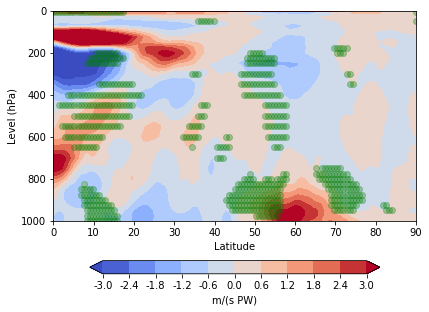

In [10]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & v vert winter  =====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    v_vert_season_series = meta.statistics.operator.seasons(v_vert_weight[:],
                                                            span=lag_winter[lag], Dim_month=True)
    stat_v_vert_ERAI = meta.statistics.operator(v_vert_season_series[3:])
    stat_v_vert_ERAI.anomaly(Dim_month=False)
    stat_v_vert_ERAI.detrend()
    stat_v_vert_ERAI.lowpass(window=30, obj='detrend')
    
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_v_vert_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_v_vert_ERAI._detrend) 
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    #label = 'Correlation coefficient'
    ticks = [i for i in np.linspace(-3,3,11)]
    label = 'm/(s PW)'
    meta.visualizer.plots.vertProfile(latitude_fields_vert_ERAI, level_fields_vert_ERAI, k, p_real,
                                      label, ticks, os.path.join(output_path, 'omet_fields',
                                      'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_v_vert_DJF_decadal.png'.format(lag)),
                                      ttest=True)
    #print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & z vert winter  =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
Create contour plot of correlation coefficient for vertical profiles.


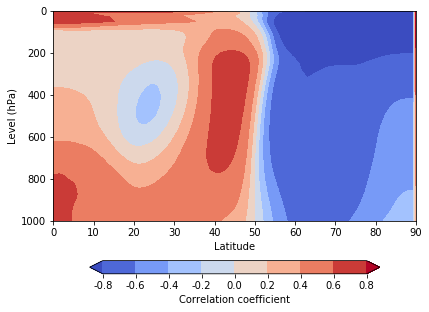

In [16]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & z vert winter  =====================')
    lag = 0
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[:-9])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    z_vert_season_series = meta.statistics.operator.seasons(z_vert_weight[:],
                                                            span=lag_winter[lag], Dim_month=True)
    stat_z_vert_ERAI = meta.statistics.operator(z_vert_season_series[9:])
    stat_z_vert_ERAI.anomaly(Dim_month=False)
    stat_z_vert_ERAI.detrend()
    stat_z_vert_ERAI.lowpass(window=30, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_z_vert_ERAI._lowpass, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.vertProfile(latitude_fields_vert_ERAI, level_fields_vert_ERAI, r, p,
                                   label, ticks, os.path.join(output_path, 'z_vert_omet', 'season',
                                   'spatial_ORAS4_atl_OMET_60N_lag_{}_ERAI_z_vert_DJF_decadal.png'.format(lag)))  

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & du vert winter  =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
One time series is regressed on a 2D field.
Create contour plot of correlation coefficient for vertical profiles.


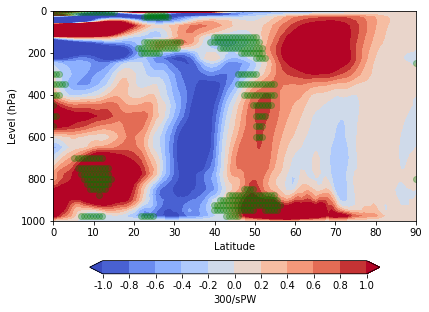

In [15]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & du vert winter  =====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    du_vert_season_series = meta.statistics.operator.seasons(du_vert_weight[:],
                                                            span=lag_winter[lag], Dim_month=True)
    stat_du_vert_ERAI = meta.statistics.operator(du_vert_season_series[3:])
    stat_du_vert_ERAI.anomaly(Dim_month=False)
    stat_du_vert_ERAI.detrend()
    stat_du_vert_ERAI.lowpass(window=30, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_du_vert_ERAI._lowpass, lag)
    
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_du_vert_ERAI._detrend)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-1,1,11)]
    #label = 'Correlation coefficient'
    label = '300/sPW'
    meta.visualizer.plots.vertProfile(latitude_fields_vert_ERAI, level_fields_vert_ERAI, k*300, p_real,
                                      label, ticks, os.path.join(output_path,
                                      'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_du_vert_DJF_decadal.png'.format(lag)),
                                      ttest=True)
    #print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & E vert winter  =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
One time series is regressed on a 2D field.
Create contour plot of correlation coefficient for vertical profiles.


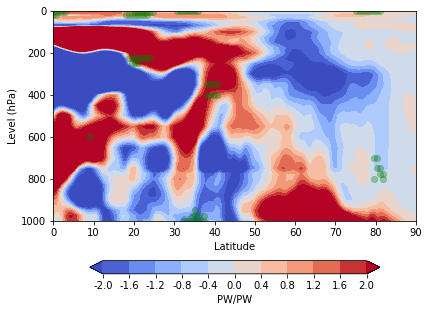

In [8]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & E vert winter  =====================')
    lag = 2
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    E_vert_season_series = meta.statistics.operator.seasons(E_vert[:],
                                                            span=lag_winter[lag], Dim_month=True)
    stat_E_vert_ERAI = meta.statistics.operator(E_vert_season_series[3:])
    stat_E_vert_ERAI.anomaly(Dim_month=False)
    stat_E_vert_ERAI.detrend()
    stat_E_vert_ERAI.lowpass(window=30, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_E_vert_ERAI._lowpass)
    
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_E_vert_ERAI._detrend)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-2,2,11)]
    #label = 'Correlation coefficient'
    label = 'PW/PW'
    meta.visualizer.plots.vertProfile(latitude_fields_vert_ERAI, level_fields_vert_ERAI, k, p_real,
                                      label, ticks, os.path.join(output_path,
                                      'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_E_vert_DJF_decadal.png'.format(lag)),
                                      ttest=True)
    #print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & cpT vert winter  =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
One time series is regressed on a 2D field.
Create contour plot of correlation coefficient for vertical profiles.


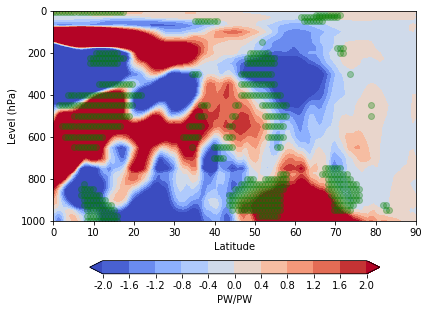

[[-0.80476317 -0.89319002 -0.98409743 -1.06950085 -1.14860247 -1.22377961
  -1.29637666 -1.3478585  -1.35233047 -1.31952464]
 [-0.69086048 -0.74821638 -0.83079012 -0.96735927 -1.12051497 -1.26253315
  -1.3739962  -1.42659797 -1.43042611 -1.42763159]
 [-0.71578524 -0.74924235 -0.86359748 -1.04323017 -1.18635087 -1.27994673
  -1.35039857 -1.39473091 -1.42668068 -1.46820346]
 [-0.7329939  -0.87859226 -1.06883467 -1.25049307 -1.31697856 -1.33296751
  -1.34915294 -1.36784061 -1.44067174 -1.55194226]
 [-0.65644509 -0.84801645 -1.04560909 -1.16946984 -1.15838862 -1.14904071
  -1.23421238 -1.3688732  -1.54277013 -1.71407868]
 [-0.74560299 -0.97708902 -1.20699831 -1.34871024 -1.40251973 -1.50816997
  -1.69468277 -1.89012338 -2.06968464 -2.18918945]
 [-0.97766866 -1.23914135 -1.46779731 -1.63553866 -1.77361623 -1.92520927
  -2.12413663 -2.35140897 -2.50303966 -2.56303693]
 [-1.98814426 -2.38991674 -2.7607793  -3.13969508 -3.54478242 -3.96682246
  -4.42046398 -4.78432779 -4.92528377 -4.95572249]


In [9]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & cpT vert winter  =====================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    cpT_vert_season_series = meta.statistics.operator.seasons(cpT_vert[:],
                                                            span=lag_winter[lag], Dim_month=True)
    stat_cpT_vert_ERAI = meta.statistics.operator(cpT_vert_season_series[3:])
    stat_cpT_vert_ERAI.anomaly(Dim_month=False)
    stat_cpT_vert_ERAI.detrend()
    stat_cpT_vert_ERAI.lowpass(window=30, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_cpT_vert_ERAI._lowpass, lag)
    
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_cpT_vert_ERAI._detrend)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-2,2,11)]
    #label = 'Correlation coefficient'
    label = 'PW/PW'
    meta.visualizer.plots.vertProfile(latitude_fields_vert_ERAI, level_fields_vert_ERAI, k, p_real,
                                      label, ticks, os.path.join(output_path,
                                      'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_cpT_vert_DJF_decadal.png'.format(lag)),
                                      ttest=True)
    print (k[10:20,30:40])

***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********
=== p 200 300 400 500 600 750 850 steady mean regression coef + winter (DJF) ===


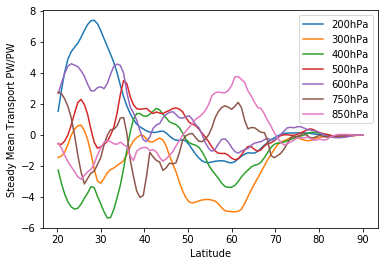

In [27]:
    print ('***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********')
    print ('=== p 200 300 400 500 600 750 850 steady mean regression coef + winter (DJF) ===')
    fig = plt.figure()
    plt.plot(latitude_fields_vert_ERAI[:94], k[14,:94], label='200hPa')
    plt.plot(latitude_fields_vert_ERAI[:94], k[17,:94], label='300hPa')
    plt.plot(latitude_fields_vert_ERAI[:94], k[19,:94], label='400hPa')
    plt.plot(latitude_fields_vert_ERAI[:94], k[21,:94], label='500hPa')
    plt.plot(latitude_fields_vert_ERAI[:94], k[23,:94], label='600hPa')
    plt.plot(latitude_fields_vert_ERAI[:94], k[26,:94], label='750hPa')
    plt.plot(latitude_fields_vert_ERAI[:94], k[30,:94], label='850hPa')
    plt.xlabel("Latitude")
    plt.legend()
    plt.ylabel("Steady Mean Transport PW/PW")
    plt.show()
    fig.savefig(os.path.join(output_path,'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_eddy_cpT_steady_mean_DJF_decadal_mean.png'.format(lag)),dpi=400)
    plt.close(fig)

In [28]:
    print(level_fields_vert_ERAI[:])
    print(latitude_fields_vert_ERAI[93])

[   1    2    3    5    7   10   20   30   50   70  100  125  150  175
  200  225  250  300  350  400  450  500  550  600  650  700  750  775
  800  825  850  875  900  925  950  975 1000]
20.25


***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & cpT vert winter  =====================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
One time series is regressed on a 2D field.
Create contour plot of correlation coefficient for vertical profiles.


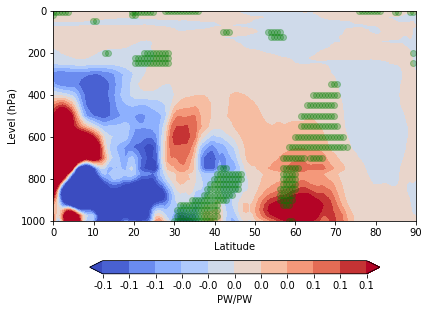

[[-1.32541517e-05 -1.66036329e-05 -1.98027338e-05 -2.29612672e-05
  -2.55738193e-05 -2.76748047e-05 -2.84697626e-05 -2.87505481e-05
  -3.00464504e-05 -3.17493524e-05]
 [-1.42193644e-05 -1.75563397e-05 -2.01365558e-05 -2.43174049e-05
  -2.88269349e-05 -3.43502450e-05 -4.06445575e-05 -4.53282707e-05
  -4.73957178e-05 -4.80790987e-05]
 [-1.08333526e-05 -1.98174997e-05 -2.70449761e-05 -3.12249473e-05
  -3.52465540e-05 -3.90351524e-05 -4.41753706e-05 -5.40767335e-05
  -6.43868979e-05 -7.25251470e-05]
 [-1.14083208e-05 -1.95275362e-05 -3.57389642e-05 -4.85383352e-05
  -5.79634832e-05 -6.74749640e-05 -7.57086280e-05 -8.41157358e-05
  -9.55962442e-05 -9.98714827e-05]
 [ 2.76869736e-05  2.10800457e-05  9.57354268e-06 -8.88233911e-06
  -1.83403585e-05 -2.97471500e-05 -3.85475047e-05 -5.81333562e-05
  -7.43809930e-05 -8.75725237e-05]
 [ 3.39705022e-05  3.54538829e-05  3.17465154e-05  1.78234989e-05
   1.11919099e-05  3.46991459e-06 -1.80269448e-05 -3.92512975e-05
  -4.72402734e-05 -4.22436415e-05

In [12]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & Lvq vert winter  =====================')
    lag = 2
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    Lvq_vert_season_series = meta.statistics.operator.seasons(Lvq_vert[:],
                                                            span=lag_winter[lag], Dim_month=True)
    stat_Lvq_vert_ERAI = meta.statistics.operator(Lvq_vert_season_series[3:])
    stat_Lvq_vert_ERAI.anomaly(Dim_month=False)
    stat_Lvq_vert_ERAI.detrend()
    stat_Lvq_vert_ERAI.lowpass(window=30, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_Lvq_vert_ERAI._lowpass, lag)
    
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_Lvq_vert_ERAI._detrend)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-0.1,0.1,11)]
    #label = 'Correlation coefficient'
    label = 'PW/PW'
    meta.visualizer.plots.vertProfile(latitude_fields_vert_ERAI, level_fields_vert_ERAI, k, p_real,
                                      label, ticks, os.path.join(output_path,
                                      'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_Lvq_vert_DJF_decadal.png'.format(lag)),
                                      ttest=True)
    print (k[10:20,30:40])